In [1]:


from tf_explain.core.grad_cam import GradCAM

import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow.keras as keras 
from tensorflow.keras import layers

import os
import sys

# append src to python path, access it as a package
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.data import load_fer


   
AUTOTUNE = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 128
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [2]:
labeled_data = load_fer.load_fer()
labeled_data




train_ds = prepare_for_training(labeled_data)



file path is Tensor("args_0:0", shape=(), dtype=string)


Image shape:  (48, 48, 3)
Label:  b'happy'


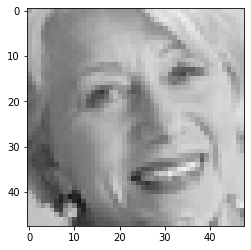

Image shape:  (48, 48, 3)
Label:  b'happy'


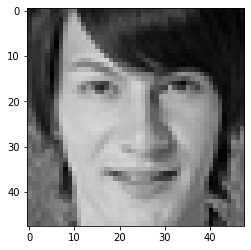

Image shape:  (48, 48, 3)
Label:  b'happy'


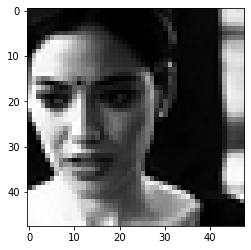

Image shape:  (48, 48, 3)
Label:  b'surprise'


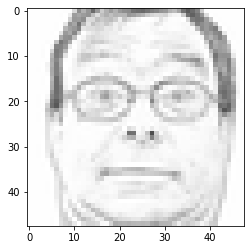

Image shape:  (48, 48, 3)
Label:  b'happy'


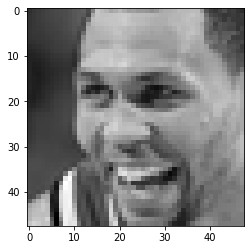

In [3]:

for image, label in labeled_data.take(5): 
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    img = image.numpy()
    plt.figure()
    plt.imshow(img)
    plt.show()


In [5]:

IMG_HEIGHT = 48
IMG_WIDTH = 48
batch_size = 64
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data

train_dir = "../data/raw/fer2013/train"
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

model = keras.Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu', name="conv3"),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7)
])
# Call model on a test input
# x = 
# y = model(x)


model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()
model.fit(train_data_gen, epochs=1)

Found 28709 images belonging to 7 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flat

In [6]:
# model.fit(train_ds.batch(1).repeat(1), epochs=1, steps_per_epoch=1)
for image, label in labeled_data.take(1):
    image = (None, image)
    label = label 
    

In [7]:
# Load pretrained model or your own
# model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)

IMAGE_PATH = "../data/raw/fer2013/test-public/1 disgust/disgust-028791.png"
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(48, 48))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=1)  # 281 is the tabby cat index in ImageNet

explainer.save(grid, ".", "grad_cam.png")

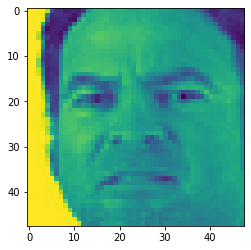

In [8]:
import matplotlib.pyplot as plt
image = plt.imread("../data/raw/fer2013/test-public/1 disgust/disgust-028791.png")
plt.imshow(image)